<a href="https://colab.research.google.com/github/Nishasathish13/TheSchoolofAI-END3.0/blob/main/TheSchoolofAI-END3.0/Session%2011_12%20-%20BERT%20and%20BART/Class%20Notes/Session_11_12_PyTorch_Lightening%2C_BERT_and_Lyrics_processing_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-prep for "BART learns to rap"

This notebook prepares the data for the "BART learns to rap" model by loading the data taken from http://www.github.com/fpaupier/RapLyrics-Scraper


In [1]:
import os
import pandas as pd
import numpy as np

import re
import math
import random

### Cloning the git repo

In [4]:
!git clone https://github.com/fpaupier/RapLyrics-Scraper

Cloning into 'RapLyrics-Scraper'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 131 (delta 3), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (131/131), 5.57 MiB | 13.05 MiB/s, done.
Resolving deltas: 100% (47/47), done.


### Or download the required lyrics folder

In [5]:
!wget 'https://github.com/fpaupier/RapLyrics-Scraper/tree/master/lyrics_US'

--2022-02-25 17:14:17--  https://github.com/fpaupier/RapLyrics-Scraper/tree/master/lyrics_US
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘lyrics_US’

lyrics_US               [ <=>                ] 224.72K  --.-KB/s    in 0.1s    

2022-02-25 17:14:17 (1.71 MB/s) - ‘lyrics_US’ saved [230118]



In [6]:
lyrics_dir = '/content/RapLyrics-Scraper/lyrics_US'
lyric_files = os.listdir(lyrics_dir)

In [8]:
with open(os.path.join(lyrics_dir, lyric_files[0]), 'r', encoding = 'utf-8') as f:
    lyrics = f.read()

In [9]:
def create_lyric_pairs(lyrics):
    ''' Function that creates pairs of lyrics
        Args: lyrics - multiple songs by an artist in a text file
        Returns: 2 lists - source and target sentences
    '''
    source = []
    target = []
    
    """
    The re.sub() function is used to replace occurrences of a particular sub-string with another sub-string.
    This function takes as input the following:

    The sub-string to replace
    The sub-string to replace with
    The actual string
    """
    lyrics_ = re.sub(r' \([^)]*\)', '', lyrics)
    lyrics_ = lyrics_.replace('(Hook)', '')

    lyrics_ = lyrics_.split('\n')

    # Clean up extra spaces in the lyrics
    counter = 0
    for i in range(len(lyrics_)-1):
        if lyrics_[counter] == "" and lyrics[counter+1] == "":
            lyrics_[counter+1].pop()
        counter += 1
    
    counter = 0
    for i in range(len(lyrics_)-1):
        if lyrics_[counter] == "" and lyrics[counter+1] == "":
            lyrics_[counter+1].pop()
        counter += 1    
    # replace a "" with the word break
    for i in range(len(lyrics_)):
        if lyrics_[i] == "":
            lyrics_[i] = "break"
    
    counter = 0
    for i in range(len(lyrics_) - 1):
        if lyrics_[counter] != "break" and lyrics_[counter+1] != "break":
            # Use one line and target is the next line
            source.append(lyrics_[counter])
            target.append(lyrics_[counter+1])
            
        counter += 1
            
    return source, target

def noise_sentence(sentence_, percent_words, replacement_token = "<mask>"):
    '''
    Args: sentence - the sentence to noise
          percent_words - the percent of words to remove
    '''
    # Create a list item and copy
    sentence_ = sentence_.split(' ')
    sentence = sentence_.copy()
    
    num_words = math.ceil(len(sentence) * percent_words)
    
    # Create an array of tokens to sample from; don't include the last word as an option because in the case of lyrics
    # that word is often a rhyming word and plays an important role in song construction
    sample_tokens = set(np.arange(0, np.maximum(1, len(sentence)-1)))
    
    words_to_noise = random.sample(sample_tokens, num_words)
    
    # Remove redundant spaces
    sentence = re.sub(r' {2,5}', ' ', ' '.join(sentence))
    
    # Combine concurrent <mask> tokens into a single token; this just does two rounds of this; more could be done
    sentence = re.sub(r'<mask> <mask>', "<mask>", sentence)
    sentence = re.sub(r'<mask> <mask>', "<mask>", sentence)
    return sentence
    

# Noise the lyrics
The process below noises the (source) lyric and creates the training data

In [10]:
source_lyrics = []
target_lyrics = []

for i in range(len(lyric_files[1])):
    with open(os.path.join(lyrics_dir, lyric_files[i]), 'r', encoding = 'utf-8') as f:
        lyrics = f.read()
        a, b = create_lyric_pairs(lyrics)
        source_lyrics.extend(a)
        target_lyrics.extend(b)

In [11]:
# Set up the dataframe
lyrics_df = pd.DataFrame({"source":source_lyrics, "target":target_lyrics})

In [12]:
# Remove duplicates; without this there's a lot of repetitiveness in the lyrics generated
lyrics_df = lyrics_df.drop_duplicates(subset = 'source')
lyrics_df = lyrics_df.drop_duplicates(subset = 'target')

In [13]:
# Clean out the lyrics that contain a ":"; this was specific to some lyrics and created some 
lyrics_df = lyrics_df[~lyrics_df.source.str.contains(":")]
lyrics_df = lyrics_df[~lyrics_df.target.str.contains(":")]
lyrics_df = lyrics_df[lyrics_df.target != "break"]


In [14]:
# Noise the source sentences
lyrics_df['source'] = lyrics_df['source'].apply(lambda x: noise_sentence(x, 0.25))

In [15]:
lyrics_df.to_csv("lyrics_simple_noised.csv", index = False)

In [17]:
lyrics_df

,source,target
0,Do you still believe in love?,Or do you like drugs?
1,Ran into a night owl rollin' White Owls,Girl it's been awhile since I hit a White Owl
2,Girl it's been awhile since I hit a White Owl,"I'm with it though, she a centerfold"
3,"I'm with it though, she a centerfold",Big ol' blunt look like tentacles
4,Big ol' blunt look like tentacles,"She strip in Europe, Interpol"
...,...,...
148411,"Or get this shit right, check it, it's the B-I...","Ya'll niggas can't see Poppa, nor the Big Moma"
148412,"Ya'll niggas can't see Poppa, nor the Big Moma","Who you love... for the Y2G, the two ten"
148413,"Who you love... for the Y2G, the two ten","We got it sewn, we don't need ya'll help, we h..."
148414,"We got it sewn, we don't need ya'll help, we h...",Cause this goes out to cats not tryin to give ...


(array([4.9917e+04, 5.3000e+01, 1.5000e+01, 9.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,  43.6,  86.2, 128.8, 171.4, 214. , 256.6, 299.2, 341.8,
        384.4, 427. ]),
 <a list of 10 Patch objects>)

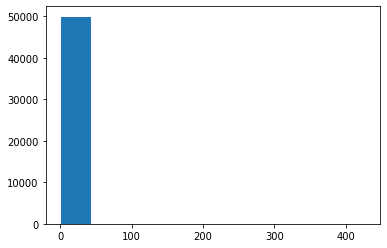

In [18]:
# Out of interest take a look at the distribution of sentence lengths
# It turns out there was something a bit funny going on here, but as the as the tokenizer limits the length of the sentences
# fed to the model, it's not really an issue (aside from the document with training data possibly being a bit larger than it needs to be)
import matplotlib.pyplot as plt

length_of_sent = []
for i in range(50000): #reducting the bounds
    length_of_sent.append(len(lyrics_df.iloc[i, 1].split(' ')))
    
plt.hist(length_of_sent)

In [19]:
# For reference, the longest sentence 400 sentences from the end of the list was only 31 tokens long
#16 in our case, because of lower bounds
length_of_sent.sort()
length_of_sent[-400]

16